# Regularization, Model Selection and Evaluation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F04_regularization_selection_validation.ipynb)

<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>
    
- [Elements of Probability Theory](appendix_elements_of_probability_theory.ipynb)  
- [Understand the overfitting-underfitting and bias-variance tradeoffs](3_overfitting_underfitting_bias_variance)
</div>

<div class="alert alert-block alert-info">
    <b>Learning Outcomes</b>
    
- Estimate the expected prediction error using cross-validation
- Use regularization to prevent overfitting
- Be aware of underlying statistical assumptions (identity, independence)
</div>

## Cross-Validation

- Data is often scarce so that living aside test data to estimate the Prediction Error (PE) is a problem
- *Cross-validation* is used to estimate the Expected PE (EPE), while avoiding living aside test data
- It uses part of the data to train, part of the data to test, repeating the operation on different subset selections

### $K$-Fold Cross Validation

1. Slice the train data into $K$ roughly equal-sized parts;
2. Keep the $K$th part for validation and train on the $K - 1$ other parts;
3. Compute the prediction error $K$ using the $K$th part;
4. Repeat the operation for all $K$ parts;
5. Average the prediction errors to estimate the EPE.

<img src="images/K-fold_cross_validation_EN.svg" width="500">


<div class="alert alert-block alert-warning">
    <b>Warning</b>
    
Cross-validation allows one to estimate **expected** prediction error rather than the prediction error conditioned on a particular training set (see Chap. 7.12 in Hastie *et al.* 2009).
</div>

### Choosing the number $K$ of parts

- **$K$ small** (e.g. $K = 2$):
    <br>biases towards large error (CV training sets size $(K - 1) / K \times N$ much smaller than original training set size $N$);
- **$K$ large** (e.g. $K = N$, leave-one out CV):
    <br>unbiased estimate of EPE, but with high variance ($N$ "training sets" are similar to each other);
- **$K = 5$ or 10**:
    <br>recommended by Hastie *et al.* (2009) as a good compromise, but depends on case study.

### Adapting Cross-Validation to the Data Structure

For instance:
- By choosing the the number of parts $K$ to adapt to cycles (e.g. avoid splitting years)
- By grouping (e.g. if measurements for different people should be kept together)
- Shuffling splits (e.g. if the ordering of the data is special)
- By taking serial correlations into account in time series.

See https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

## Regularizing to Avoid Overfitting: Linear Models

### Linear Models Can Overfit

- Linear models are simpler than alternatives
  
  $\rightarrow$ they tend to overfit less than alternatives
- They even often underfit when:
  - $p$ is relatively small
  - the problem is not linearly separable
  

- But linear models can also overfit, when:
  - $N$ is relatively small
  - Many uninformative features (they depend a lot on other features)

### Effect of uninformative features

Recall from [Ordinary Least Squares](03_ordinary_least_squares.ipynb) that, if we assume that generating model is $Y = \mathbf{X}^\top \boldsymbol{\beta} + \epsilon$, where the observations of $\epsilon$ are *uncorrelated* and with *mean zero* and *constant variance* $\sigma^2$, then,

$$
\begin{aligned}
\mathbb{E}(\hat{\boldsymbol{\beta}} | \mathbf{X}) &= \boldsymbol{\beta}\\
\mathrm{Var}(\hat{\boldsymbol{\beta}} | \mathbf{X}) &= \sigma^2 (\mathbf{X}^\top \mathbf{X})^{-1}.
\end{aligned}
$$

#### 2D example

Assume that $\boldsymbol{X} = (X_0, X_1)$ centered with $X_1 = c X_0 + (1- c) Z_1$ and
\begin{align}
\begin{cases}
\mathrm{Var}(X_0) = 1, &\mathrm{Cov}(X_0, Y) = 1, \\
\mathrm{Var}(Z_1) = 1, &\mathrm{Cov}(Z_1, Y) = 0, &\mathrm{Cov}(Z_1, X_0) = 0.
\end{cases}
\end{align}

$$
\mathrm{Then,~}
\mathbb{E}\left(\frac{\mathbf{X}^\top \mathbf{X}}{N - 1}\right) =
\begin{pmatrix}
    1 & c\\
    c & 1
\end{pmatrix}
\mathrm{~and~}
\mathbb{E}\left(\frac{\mathbf{X}^\top \mathbf{y}}{N - 1}\right) =
\begin{pmatrix}
    1\\
    c
\end{pmatrix},
$$

$$
\mathrm{Thus,~}
\mathbb{E}\left(\left(\frac{\mathbf{X}^\top \mathbf{X}}{N - 1}\right)^{-1}\right) = \frac{1}{1 - c^2}
\begin{pmatrix}
    1 & -c\\
    -c & 1
\end{pmatrix}
\mathrm{~and~}
\mathbb{E}\left(\hat{\boldsymbol{\beta}}\right) = 
\begin{pmatrix}
    1\\
    0
\end{pmatrix}.
$$

Thus,

$$
\begin{aligned}
\mathbb{E}(\mathrm{Var}(\hat{\boldsymbol{\beta}} | \mathbf{X})) &=
\frac{1}{1 - c^2}
\begin{pmatrix}
    1 & -c\\
    -c & 1
\end{pmatrix}.
\end{aligned}
$$

So, a large absolute value of **inputs correlation** imply

- large **coef. variance**, i.e. coef. errors
- large **coef. covariance**, i.e. errors in one coef. associated with errors in the other

> ***Question (optional)***
> - Interpret the role of covariances between inputs in OLS for $M > 2$ using an eigendecomposition of the covariance matrix.


#### Looking for a solution to the confusion problem

Many correlated variables $\rightarrow$ high variance.

A widely large positive coefficient on one variable can be canceled by a similarly large negative coefficient on its correlated cousin.

<div class="alert alert-block alert-info">
    <b>Idea: weight-decay penalization</b>
    
Limit the size of the coefficients to reduce the variance of the coefficients and predictions.
</div>

### Ridge Regression

#### Ridge Regression Problem

- A very common form of regularization for linear regression;
- Shrink coefficients by imposing a penalty on their size;
- Minimize a penalized RSS:

\begin{equation}
\hat{\boldsymbol{\beta}}^\mathrm{ridge} = \underset{\boldsymbol{\beta}}{\mathrm{argmin}} \left\{\sum_{i = 1}^N \left(y_i - \beta_0 - \sum_{j = 1}^p x_{ij} \beta_j \right)^2 + \lambda \sum_{j = 1}^p \beta_j^2 \right\}.
\end{equation}

$\lambda \ge 0$ controls the amount of shrinkage.

#### Ridge Regression as a Constrained Optimization Problem

For any $\lambda$ there exists a $t \ge 0$ such that the ridge regression problem is equivalent to:

\begin{equation}
\hat{\boldsymbol{\beta}}^\mathrm{ridge} = \underset{\boldsymbol{\beta}}{\mathrm{argmin}} \sum_{i = 1}^N \left(y_i - \beta_0 - \sum_{j = 1}^p x_{ij} \beta_j \right)^2\\
\mathrm{subject~to~} \sum_{j = 1}^p \beta_j^2 \le t.
\end{equation}

<div class="alert alert-block alert-warning">
    <b>Warning 1</b>
    
Contrary to OLS and as for many regularization methods, Ridge solutions are not equivarient under scaling:
    
- If different inputs represent different kinds of variables, one normally standardizes the inputs before solving.
- If different inputs represent measurements of the same variable in different situations (location, epoch...), it may be interesting to keep the scales.
</div>

<div class="alert alert-block alert-warning">
    <b>Warning 2</b>
    
- Penalization of the intercept would make the procedure depend on the origin
chosen for $Y$.
- After centering the inputs by replacing each $x_{ij}$ by $x_{ij} - \bar{x}_j$, OLS gives $\hat{\beta}_0 = \bar{y}$.
- We can thus first solve the ridge for centered inputs and outputs and then add $\hat{\beta}_0 = \bar{y}$ to the predictions.
</div>

#### Effect of Ridge Penality on Coefficients

> ***Question (optional)***
> - Show that the solution to the ridge-penalized RSS is
> \begin{equation}
    \hat{\boldsymbol{\beta}}^\mathrm{ridge} = \left(\mathbf{X}^\top \mathbf{X} + \lambda \mathbf{I}\right)^{-1} \left(\mathbf{X}^\top \mathbf{y}\right),
\end{equation}
> where $\mathbf{I}$ is the $p\times p$ identity matrix.

> ***Question***
> - How does this formula differ from the OLS solution for the coefficients?
> - When are these solutions unique?

> ***Question (optional)***
> - Show that in the case of **orthonormal inputs**, the ridge estimates are just a scaled version of the OLS estimates: $\hat{\boldsymbol{\beta}}^\mathrm{ridge} = \hat{\boldsymbol{\beta}} / (1 + \lambda)$.

> ***Question***
> - Use this formula to interpret the effect of the Ridge regularization on the coefficients for orthonormal inputs.

#### Ridge Penalty Effect on Variance

Assume again that the generating model is $Y = \mathbf{X}^\top \boldsymbol{\beta} + \epsilon$, where the observations of $\epsilon$ are *uncorrelated* and with *mean zero* and *constant variance* $\sigma^2$

> ***Question (optional)***
> - Show that
$$
\mathrm{Var}(\hat{\boldsymbol{\beta}} | \mathbf{X}) = \sigma^2 (\mathbf{X}^\top \mathbf{X} + \lambda \mathbf{I})^{-1}.
$$

#### Singular Value Decomposition Interpretation (optional)

Let the SVD of $\mathbf{X}$ be $\mathbf{X} = \mathbf{U} \mathbf{D} \mathbf{V}^\top$ with:
- $\mathbf{U}$ an $N \times p$ orthogonal matrix with columns spanning the column space of $\mathbf{X}$;
- $\mathbf{V}$ a $p \times p$ orthogonal matrix with columns spanning the row space of $\mathbf{X}$;
- $\mathbf{D}$ a $p \times p$ diagonal matrix with diagonal entries $d_1 \ge d_2 \ge \cdots d_p \ge 0$ called the singular values of $\mathbf{X}$.

> ***Question (optional)***
> - Show that the OLS estimates are such that $\mathbf{X} \hat{\boldsymbol{\beta}} = \mathbf{U} \mathbf{U}^\top \mathbf{y} = \sum_{j = 1}^p \mathbf{u}_j \mathbf{u}_j^\top \mathbf{y}$.
> - Show that the ridge estimates are such that $\mathbf{X} \hat{\boldsymbol{\beta}}^\mathrm{ridge} = \sum_{j = 1}^p \mathbf{u}_j \frac{d_j^2}{d_j^2 + \lambda} \mathbf{u}_j^\top \mathbf{y}$.

> ***Question***
> - Interpret how the ridge shrinks the coefficients $\hat{\boldsymbol{\beta}}$ with respect to the orthonormal basis $\mathbf{V}$.
> - What is the role of $\mathrm{df}(\lambda) := \mathrm{tr}\left[\mathbf{X}(\mathbf{X}^\top \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^\top\right] = \sum_{j = 1}^p \frac{d_j^2}{d_j^2 + \lambda}$?

#### Regularization on a Simple Example

<img src="images/linreg_noreg_0_nogrey.svg" width="400" style="float:left;margin-right=25px">

- Small training set
- Fit a linear model without regularization

#### Regularization on a Simple Example

<img src="images/linreg_noreg_0.svg" width="400" style="float:left;margin-right=25px">

- Small training set
- Fit a linear model without regularization
- Training points sampled at random
- Can overfit if the data is noisy!

#### Regularization on a Simple Example: Random Training Sets

| <img src="images/linreg_noreg_0.svg" width="300"> | <img src="images/linreg_noreg_1.svg" width="300"> | <img src="images/linreg_noreg_2.svg" width="300"> |
|---|---|---|
| <img src="images/linreg_noreg_3.svg" width="300"> | <img src="images/linreg_noreg_4.svg" width="300"> | <img src="images/linreg_noreg_5.svg" width="300"> |

#### Bias-Variance Tradeoff in Ridge Regression

<div style="text-align:center;float:left">
    
<img src="images/linreg_noreg_0.svg" width="400">
    
<div>

**Linear** regression (OLS)
<br>
High variance, no bias
</div>
</div>
<div style="text-align:center;float:right">
    
<img src="images/ridge_0_withreg.svg" width="400">
    
<div>

**Ridge** regression
<br>
Low variance, but biased!
</div>
</div>

<div style="clear:both"></div>

### Bias-Variance Tradeoff in Ridge Regression

| <img src="images/ridge_alpha_0.svg" width="100%"> | <img src="images/ridge_alpha_50.svg" width="100%"> | <img src="images/ridge_alpha_500.svg" width="100%"> |
|---|---|---|
|  Too much variance  |  Best tradeoff  |  Too much bias  |

### Partial Summary

- Can overfit when:
  - $N$ is too small and $p$ is large
  - In particular with non-informative features
- Regularization for regression:
  - From linear regression to ridge regression $\rightarrow$ less overfit
  - large regularization parameter $\rightarrow$ strong regularization $\rightarrow$ smaller coefficients

## Tuning Hyperparameters (model selection)

- Some **hyperparameters** need to be estimated in addition to coefficients (regularization parameter, nonlinear coefficients in linear models, etc.)
- Validation data or Cross-Validation (CV) may be used to **select the best hyperparameters** by minimizing the estimated validation error (grid search, random search, etc.)

<img src="images/grid_search_workflow.png" width="400">

### Testing after validation


The best validation error is for hyperparameters that were **trained using the validation data**: it is **not the EPE** for this choice of hyperparameters!

$\rightarrow$ Distinguish between **train**, **validation** and **test data**

Training and validation can be combined using CV but **test data should be kept to evaluate the PE conditionned on the CV set** for the final choice of coefficients and hyperparameters.

To maximize the use of the data and estimate the EPE, **nested CV** can be used.

## Law of Large Numbers?

Estimates attempt to minimize a function of the training error $\overline{\mathrm{err}}$.

For estimates to converge with the sample size, so should $\overline{\mathrm{err}}$.

$\rightarrow$ We need some **Law of Large Numbers** to be applicable.

Basic assumptions: **independent** and **identically distributed**.

### What could go wrong?

So far, we have assumed that the joint distribution $f_{\boldsymbol{X}, Y}$ is **independent of time**.

In particular, we have assumed that the joint process is **statistically stationary**.

Yet, in the natural and engineering sciences, **variables** often depend on **time** as well as **distributions** (cycles, trends).

Variations in time can rarely be considered purely random:

$\rightarrow$ some **dependence** persist between realizations

Yet, we are fine if we can show that:
- there is a **stationary distribution**
- realizations sufficiently distant in time **no longer correlate**

### Violation of Statistical Stationarity

<div style="float:left;margin-right:20px">
    
<img src="images/640px-20200324_Global_average_temperature_-_NASA-GISS_HadCrut_NOAA_Japan_BerkeleyE.svg.png" width="400">

[By RCraig09 - Own work, CC BY-SA 4.0](https://commons.wikimedia.org/w/index.php?curid=88535596)
</div>

Surface air temperature variability can be decomposed into:

$-$ (pseudo-)periodic **cycles** (diurnal, annual, Milankovitch)

$-$ a **continuous spectrum** of frequencies due to chaotic dynamics

$-$ an increasing **trend** due to global warming

$-$ other non-equilibrium variations (effect of volcanoes, solar activity, ...)

### Violation of Independence

**Climate perspective:** Weather conditions tend to **persist** for a while so that observations that are close in time are more likely to be similar than observations distant in time.

**Dynamical system perspective:** The evolution of the state of the atmosphere can be described by a system of differential equations whose solutions are relatively **smooth** (not completely erratic).

**Probabilistic perspective:** This **memory** corresponds to a (serial) **dependence** between an observation at one time step and an observation at a previous time step. The **auto-correlation** for a given lag is a measure of **linear dependence**.

**Example:** Serial dependence in the Paris climate (from ERA5).

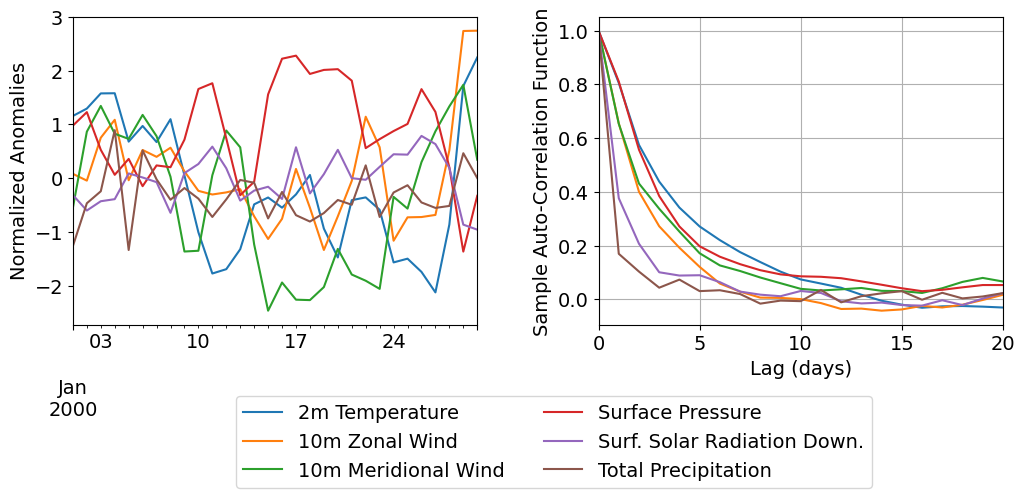

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict(header=0, index_col=0, parse_dates=True)

# Set first and last years
FIRST_YEAR = 2000
LAST_YEAR = 2009

# Define temperature filepath
filename = 'era5_paris_sf_{}_{}.csv'.format(
    FIRST_YEAR, LAST_YEAR)
filepath = Path(data_dir, filename)

# Read ERA5 time series for Paris
df = pd.read_csv(filepath, **kwargs_read_csv).resample('D').mean()
df.index = pd.DatetimeIndex(df.index.date, name='time')
da = df.to_xarray()

# Get anomalies
gp = da.groupby('time.dayofyear')
da_clim = gp.mean('time')
da_anom = gp - da_clim
df_anom = da_anom.to_pandas()
del df_anom['dayofyear']

# Variable selection
VARIABLE_NAMES = ['t2m', 'u10', 'v10', 'sp', 'ssrd', 'tp']
VARIABLE_LONG_NAMES = {
    't2m': '2m Temperature',
    'u10': '10m Zonal Wind',
    'v10': '10m Meridional Wind',
    'sp': 'Surface Pressure',
    'ssrd': 'Surf. Solar Radiation Down.',
    'tp': 'Total Precipitation'
}

# Plot time series
NDAYS_SERIES = 30


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
(df_anom / df_anom.std())[VARIABLE_NAMES].iloc[:NDAYS_SERIES].plot(ax=ax[0])
ax[0].set_ylabel('Normalized Anomalies')
ax[0].set_xlabel('')
ax[0].get_legend().remove()

# Plot auto-correlation functions
NDAYS_ACF = 21

nt = len(df_anom)
for variable_name in VARIABLE_NAMES:
    s = df_anom[variable_name]
    variable_long_name = VARIABLE_LONG_NAMES[variable_name]
    acf = np.correlate(s, s, 'full')[nt - 1:] / s.var() / (nt - 1)  
    ax[1].plot(acf[:NDAYS_ACF], label=variable_long_name)
ax[1].set_xlabel('Lag (days)')
ax[1].set_ylabel('Sample Auto-Correlation Function')
ax[1].set_xlim(0, NDAYS_ACF - 1)
labels = [VARIABLE_LONG_NAMES[variable_name]
          for variable_name in VARIABLE_NAMES]
plt.legend(labels=labels, bbox_to_anchor=(0.7, -0.2), ncols=2)
plt.subplots_adjust(wspace=0.3)
_ = ax[1].grid(True)

### Partial Summary

- In statistics, we **always** make assumptions about the probability distribution of the data (stationarity, independence, parametric form, etc.)
- The quality of statistics (predictions, error estimates, etc.) depends on the validity of these assumptions
- **Even the best validation could be wrong** about predictions if the new data does not satisfy these assumptions!

## To go further

- [Linear model inspection in Scikit-learn course](https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html#linear-model-inspection);
- [Introduction of the evaluation metrics in Scikit-learn course](https://inria.github.io/scikit-learn-mooc/evaluation/02_metrics.html#introduction-of-the-evaluation-metrics);
- *Generalized CV* approximation of leave-one out CV (Chap. 7.10 in Hastie *et al.* 2009);
- The *bootstrap* as a way of assessing the accuracy of a parameter estimate or a prediction (shuffled version of cross-validation, Chap. 7.11 and 8 in Hastie *et al.* 2009).
- Avoiding validation thanks to Bayesian approach.

## References

- [James, G., Witten, D., Hastie, T., Tibshirani, R., n.d. *An Introduction to Statistical Learning*, 2st ed. Springer, New York, NY.](https://www.statlearning.com/)
- Chap. 2, 3 and 7 in [Hastie, T., Tibshirani, R., Friedman, J., 2009. *The Elements of Statistical Learning*, 2nd ed. Springer, New York.](https://doi.org/10.1007/978-0-387-84858-7)
- Chap. 5 and 7 in [Wilks, D.S., 2019. *Statistical Methods in the Atmospheric Sciences*, 4th ed. Elsevier, Amsterdam.](https://doi.org/10.1016/C2017-0-03921-6)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>